In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import traceback
from matplotlib.patches import Ellipse
from scipy.spatial import ConvexHull
import warnings
warnings.filterwarnings('ignore')


In [4]:
with open('mcmc_results_20260126_150843.pkl', 'rb') as f:
    data = pickle.load(f)
    print("✓ Archivo cargado exitosamente")

✓ Archivo cargado exitosamente


In [5]:
print(f"\nTipo de estructura: {type(data)}")



Tipo de estructura: <class 'dict'>


In [6]:
# Ejemplo 1: Ver todas las claves
claves = list(data.keys())
print("Claves disponibles:", claves)

# Ejemplo 2: Acceder a una clave específica
if 'samples' in data:
    muestras = data['samples']
    print(f"Muestras shape: {muestras.shape}")

# Ejemplo 3: Explorar una clave específica
clave_interes = 'samples'  # cambia esto por la clave que quieras explorar
if clave_interes in data:
    valor = data[clave_interes]
    print(f"\nValor de '{clave_interes}':")
    print(f"Tipo: {type(valor)}")
    if hasattr(valor, 'shape'):
        print(f"Shape: {valor.shape}")
    print(f"Primeros valores:\n{valor[:3] if hasattr(valor, '__getitem__') else valor}")

Claves disponibles: ['sampler_chain', 'sampler_lnprobability', 'flat_chain', 'flat_lnprobability', 'acceptance_fraction', 'random_state', 'best_params', 'best_lnprob', 'initial_params', 'labels', 'config']


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import corner
from matplotlib import gridspec

def create_adaptive_corner_plot_from_data(data, true_params=None, grid_params=None,
                                          labels=['Latitude [°]', 'Longitude [°]', 'Spot Radius [°]'],
                                          save_path='mcmc_corner_plot.png'):
    """
    Creates an adaptive corner plot from serialized MCMC data.
    
    Args:
        data: Dictionary with MCMC results (loaded from .pkl)
        true_params: Array with true parameters [lat, lon, radii] (optional)
        grid_params: Array with grid search best fit (optional)
        labels: List of parameter names
        save_path: Path to save the plot
    """
    
    # 1. Verify we have required data
    required_keys = ['sampler_chain', 'flat_chain', 'best_params']
    for key in required_keys:
        if key not in data:
            raise ValueError(f"Missing required key: '{key}' in data")
    
    # Get MCMC chains
    chain = data['sampler_chain']  # [chains, iterations, parameters]
    flat_chain = data['flat_chain']  # [total_samples, parameters]
    mcmc_best = data['best_params']  # best MCMC parameters
    
    n_chains, n_iter, n_params = chain.shape
    total_samples = n_chains * n_iter
    
    print(f"\n📊 MCMC STATISTICS:")
    print(f"   Chains: {n_chains}")
    print(f"   Iterations per chain: {n_iter}")
    print(f"   Parameters: {n_params}")
    print(f"   Total samples: {total_samples:,}")
    print(f"   Acceptance rate: {np.mean(data['acceptance_fraction']):.3f}")
    
    # 2. Function for simple diagnostic plot (few samples)
    def create_simple_diagnostic_plot(chain, true_params, grid_params, mcmc_best):
        """Simple plot for when there are few samples"""
        fig = plt.figure(figsize=(15, 10))
        gs = gridspec.GridSpec(3, 3, figure=fig)
        
        # Trace plots per parameter
        for i in range(n_params):
            ax = fig.add_subplot(gs[i, 0])
            for c in range(min(n_chains, 4)):  # Show max 4 chains
                ax.plot(chain[c, :, i], alpha=0.7, label=f'Chain {c}' if i == 0 else "")
            ax.set_ylabel(labels[i] if labels else f'Parameter {i}')
            if i == 0:
                ax.legend(loc='upper right', fontsize=8)
            if true_params is not None:
                ax.axhline(true_params[i], color='red', linestyle='--', alpha=0.7, label='True')
        
        # 1D distributions
        for i in range(n_params):
            ax = fig.add_subplot(gs[i, 1])
            all_samples = chain[:, :, i].flatten()
            ax.hist(all_samples, bins=30, density=True, alpha=0.7, edgecolor='black')
            ax.set_ylabel('Density')
            ax.set_xlabel(labels[i] if labels else f'Parameter {i}')
            
            # Mark important values
            colors = {'MCMC': 'blue', 'Grid': 'green', 'True': 'red'}
            if mcmc_best is not None:
                ax.axvline(mcmc_best[i], color=colors['MCMC'], linestyle='-', linewidth=2, label='MCMC')
            if grid_params is not None:
                ax.axvline(grid_params[i], color=colors['Grid'], linestyle='--', linewidth=2, label='Grid')
            if true_params is not None:
                ax.axvline(true_params[i], color=colors['True'], linestyle=':', linewidth=2, label='True')
            
            if i == 0:
                ax.legend(loc='upper right', fontsize=8)
        
        # 2D scatter (only first 2 parameters if available)
        if n_params >= 2:
            ax = fig.add_subplot(gs[0:2, 2])
            for c in range(min(n_chains, 4)):
                ax.scatter(chain[c, :, 0], chain[c, :, 1], alpha=0.5, s=10, label=f'Chain {c}' if c == 0 else "")
            
            ax.set_xlabel(labels[0] if labels else 'Parameter 0')
            ax.set_ylabel(labels[1] if labels else 'Parameter 1')
            
            # Mark important points
            if mcmc_best is not None:
                ax.scatter(mcmc_best[0], mcmc_best[1], color='blue', s=100, marker='*', label='MCMC', zorder=5)
            if grid_params is not None:
                ax.scatter(grid_params[0], grid_params[1], color='green', s=100, marker='s', label='Grid', zorder=5)
            if true_params is not None:
                ax.scatter(true_params[0], true_params[1], color='red', s=100, marker='X', label='True', zorder=5)
            
            ax.legend(loc='upper right', fontsize=8)
        
        plt.suptitle(f'MCMC Diagnostics ({total_samples} samples)', fontsize=16, y=1.02)
        return fig
    
    # 3. Function for basic corner plot
    def create_basic_corner(flat_samples, true_params, grid_params, mcmc_best, labels):
        """Basic corner plot for moderate samples"""
        fig = corner.corner(
            flat_samples,
            labels=labels[:n_params] if labels else None,
            truths=true_params,
            truth_color='red',
            show_titles=True,
            title_fmt='.3f',
            title_kwargs={"fontsize": 10},
            label_kwargs={"fontsize": 12},
            quantiles=[best_parameters],
            verbose=False
        )
        
        # Extract axes from corner plot
        ndim = flat_samples.shape[1]
        axes = np.array(fig.axes).reshape((ndim, ndim))
        
        # Mark grid best if available
        if grid_params is not None:
            for i in range(ndim):
                for j in range(ndim):
                    ax = axes[i, j]
                    if i == j:
                        # In 1D histograms
                        ylim = ax.get_ylim()
                        ax.plot([grid_params[i], grid_params[i]], ylim, 
                               color='green', linestyle='--', linewidth=1.5, alpha=0.8)
                    elif i > j:
                        # In 2D scatter plots
                        ax.scatter(grid_params[j], grid_params[i], 
                                  color='green', s=50, marker='s', alpha=0.8, zorder=5)
        
        # Mark MCMC best
        for i in range(ndim):
            for j in range(ndim):
                ax = axes[i, j]
                if i == j:
                    # In 1D histograms
                    ylim = ax.get_ylim()
                    ax.plot([mcmc_best[i], mcmc_best[i]], ylim, 
                           color='blue', linestyle='-', linewidth=2, alpha=0.8)
                elif i > j:
                    # In 2D scatter plots
                    ax.scatter(mcmc_best[j], mcmc_best[i], 
                              color='blue', s=80, marker='*', alpha=0.8, zorder=6)
        
        fig.suptitle(f'MCMC Posterior Distribution\n({flat_samples.shape[0]:,} samples)', 
                    fontsize=16, y=1.02)
        return fig
    
    # 4. Function for enhanced corner plot (with burn-in)
    def create_enhanced_corner(flat_samples, true_params, grid_params, mcmc_best, labels):
        """Enhanced corner plot with detailed statistics"""
        # Calculate statistics
        means = np.mean(flat_samples, axis=0)
        medians = np.median(flat_samples, axis=0)
        stds = np.std(flat_samples, axis=0)
        ci_low = np.percentile(flat_samples, 2.5, axis=0)
        ci_high = np.percentile(flat_samples, 97.5, axis=0)
        
        # Create corner plot
        fig = corner.corner(
            flat_samples,
            labels=labels[:n_params] if labels else None,
            truths=true_params,
            truth_color='red',
            show_titles=True,
            title_fmt='.3f',
            title_kwargs={"fontsize": 10},
            label_kwargs={"fontsize": 12},
            quantiles=[0.16, 0.5, 0.84],
            verbose=False,
            plot_datapoints=True,
            plot_density=True,
            plot_contours=True,
            fill_contours=True,
            levels=[0.68, 0.95],
            color='blue',
            alpha=0.5
        )
        
        # Add custom legend
        ndim = flat_samples.shape[1]
        axes = np.array(fig.axes).reshape((ndim, ndim))
        
        # Create legend in top right corner
        legend_elements = []
        legend_labels = []
        
        if true_params is not None:
            legend_elements.append(plt.Line2D([0], [0], color='red', linestyle=':', linewidth=2))
            legend_labels.append('True value')
        
        if grid_params is not None:
            legend_elements.append(plt.Line2D([0], [0], color='green', linestyle='--', linewidth=2))
            legend_labels.append('Grid search')
        
        legend_elements.append(plt.Line2D([0], [0], color='blue', linestyle='-', linewidth=2))
        legend_labels.append('MCMC (best)')
        
        legend_elements.append(plt.Line2D([0], [0], color='blue', alpha=0.5, linewidth=10))
        legend_labels.append('Posterior distribution')
        
        # Add legend to first subplot
        axes[0, 0].legend(legend_elements, legend_labels, 
                         loc='upper right', fontsize=8, frameon=True)
        
        # Add statistics table
        stats_text = "Posterior statistics:\n"
        for i in range(ndim):
            param_name = labels[i] if labels else f'Param {i}'
            stats_text += f"{param_name}: {medians[i]:.3f} "
            stats_text += f"({ci_low[i]:.3f}, {ci_high[i]:.3f})\n"
        
        # Add text in bottom left corner
        axes[-1, 0].text(0.02, 0.98, stats_text,
                        transform=axes[-1, 0].transAxes,
                        fontsize=8, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        fig.suptitle(f'Complete MCMC Analysis\n{flat_samples.shape[0]:,} samples after burn-in', 
                    fontsize=16, y=1.02)
        return fig
    
    # 5. DECISION: What type of plot to make?
    if total_samples < 50:
        print("🔍 Few samples (<50): Creating diagnostic plot...")
        fig = create_simple_diagnostic_plot(chain, true_params, grid_params, mcmc_best)
        
    elif total_samples < 200:
        print("📈 Moderate samples (50-200): Corner plot with all samples...")
        # Use flat_chain which is already flattened
        fig = create_basic_corner(flat_chain, true_params, grid_params, mcmc_best, labels)
        
    else:
        print("📊 Many samples (≥200): Complete corner plot with burn-in...")
        # Apply burn-in (first 20%)
        discard = int(0.2 * n_iter)
        if discard > 0:
            chain_burned = chain[:, discard:, :]
            flat_samples = chain_burned.reshape(-1, n_params)
        else:
            flat_samples = flat_chain
        
        # Thin if too many samples
        if flat_samples.shape[0] > 10000:
            thin = max(1, flat_samples.shape[0] // 5000)
            flat_samples = flat_samples[::thin]
            print(f"   Thinned by factor {thin}: {flat_samples.shape[0]:,} samples")
        
        fig = create_enhanced_corner(flat_samples, true_params, grid_params, mcmc_best, labels)
    
    # 6. Save and display
    plt.tight_layout()
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Plot saved as: {save_path}")
    
    # 7. Print parameter comparison
    print("\n" + "="*60)
    print("PARAMETER COMPARISON")
    print("="*60)
    
    # Prepare data for table
    param_info = []
    for i in range(n_params):
        param_name = labels[i] if labels and i < len(labels) else f'Parameter {i}'
        
        # Get MCMC statistics
        samples = flat_chain[:, i]
        mcmc_median = np.median(samples)
        mcmc_ci_low = np.percentile(samples, 2.5)
        mcmc_ci_high = np.percentile(samples, 97.5)
        
        param_info.append({
            'name': param_name,
            'true': true_params[i] if true_params is not None and i < len(true_params) else None,
            'grid': grid_params[i] if grid_params is not None and i < len(grid_params) else None,
            'mcmc_best': mcmc_best[i] if mcmc_best is not None and i < len(mcmc_best) else None,
            'mcmc_median': mcmc_median,
            'mcmc_ci': (mcmc_ci_low, mcmc_ci_high)
        })
    
    # Print table
    print(f"{'Parameter':<15} {'True':<10} {'Grid':<10} {'MCMC (best)':<12} {'MCMC (median)':<15} {'95% CI':<15}")
    print("-" * 80)
    
    for info in param_info:
        true_str = f"{info['true']:.3f}" if info['true'] is not None else "N/A"
        grid_str = f"{info['grid']:.3f}" if info['grid'] is not None else "N/A"
        mcmc_best_str = f"{info['mcmc_best']:.3f}" if info['mcmc_best'] is not None else "N/A"
        mcmc_median_str = f"{info['mcmc_median']:.3f}"
        ci_str = f"[{info['mcmc_ci'][0]:.3f}, {info['mcmc_ci'][1]:.3f}]"
        
        print(f"{info['name']:<15} {true_str:<10} {grid_str:<10} {mcmc_best_str:<12} {mcmc_median_str:<15} {ci_str:<15}")
    
    # Calculate differences if true values are available
    if true_params is not None:
        print("\n" + "="*60)
        print("DIFFERENCES FROM TRUE VALUES")
        print("="*60)
        
        for i, info in enumerate(param_info):
            if info['true'] is not None and info['mcmc_best'] is not None:
                delta_best = info['mcmc_best'] - info['true']
                delta_median = info['mcmc_median'] - info['true']
                percent_error_best = abs(delta_best / info['true']) * 100 if info['true'] != 0 else np.nan
                percent_error_median = abs(delta_median / info['true']) * 100 if info['true'] != 0 else np.nan
                
                print(f"{info['name']}:")
                print(f"  Best MCMC: Δ = {delta_best:+.4f} ({percent_error_best:.2f}%)")
                print(f"  MCMC median: Δ = {delta_median:+.4f} ({percent_error_median:.2f}%)")
    
    return fig, mcmc_best


# COMPLETE USAGE FUNCTION
def run_mcmc_analysis(data_file='mcmc_results_20260126_150843.pkl', 
                      true_params=None, grid_params=None,
                      save_path='mcmc_analysis_results.png'):
    """
    Complete function to run MCMC analysis from .pkl file
    
    Args:
        data_file: Path to .pkl file with MCMC results
        true_params: True parameters [optional]
        grid_params: Grid search parameters [optional]
        save_path: Path to save results
    """
    
    # 1. Load data
    import pickle
    
    print("📂 Loading MCMC data...")
    with open(data_file, 'rb') as f:
        data = pickle.load(f)
    print("✅ Data loaded successfully")
    
    # 2. Show basic information
    print("\n" + "="*60)
    print("MCMC DATASET INFORMATION")
    print("="*60)
    
    chain = data['sampler_chain']
    n_chains, n_iter, n_params = chain.shape
    
    print(f"Chains: {n_chains}")
    print(f"Iterations per chain: {n_iter}")
    print(f"Parameters: {n_params}")
    print(f"Total samples: {n_chains * n_iter:,}")
    print(f"Acceptance rate: {data['acceptance_fraction']}")
    print(f"Best lnprob: {data.get('best_lnprob', 'N/A')}")
    
    if 'labels' in data:
        print(f"Parameter labels: {data['labels']}")
    
    # 3. Create adaptive corner plot
    print("\n" + "="*60)
    print("CREATING ADAPTIVE CORNER PLOT")
    print("="*60)
    
    # Define labels (use dataset labels or defaults)
    labels = data.get('labels', ['Latitude [°]', 'Longitude [°]', 'Spot Radius [°]'])
    
    # Create the plot
    fig, mcmc_best = create_adaptive_corner_plot_from_data(
        data=data,
        true_params=true_params,
        grid_params=grid_params,
        labels=labels,
        save_path=save_path
    )
    
    # 4. Show the plot
    plt.show()
    
    # 5. Return results
    return {
        'figure': fig,
        'mcmc_best_params': mcmc_best,
        'data': data,
        'summary': {
            'n_chains': n_chains,
            'n_iterations': n_iter,
            'n_parameters': n_params,
            'total_samples': n_chains * n_iter,
            'acceptance_rate': np.mean(data['acceptance_fraction']),
            'labels': labels
        }
    }



    
    # Example 2: With true and grid parameters (if you have them)
    # true_params_example = [45.0, -120.0, 15.0]  # Example: [lat, lon, radius]
    # grid_params_example = [44.8, -119.5, 14.5]  # Example from grid search
    
    # results2 = run_mcmc_analysis(
    #     data_file='mcmc_results_20260126_150843.pkl',
    #     true_params=true_params_example,
    #     grid_params=grid_params_example,
    #     save_path='mcmc_analysis_complete.png'
    # )lue


📊 MCMC STATS: 130 steps × 20 walkers = 2600 samples
📊 Many samples (≥100): Complete corner plot with burn-in...
✅ Plot saved as: mcmc_results.png

PARAMETER COMPARISON
Parameter    True       Grid       MCMC       Δ         
------------------------------------------------------------
Latitude [°] 16.810     -20.000    -19.846       -36.656
Longitude [°] 176.000    180.000    171.192        -4.808
Spot Radius [°] 12.170     5.000      5.220          -6.950


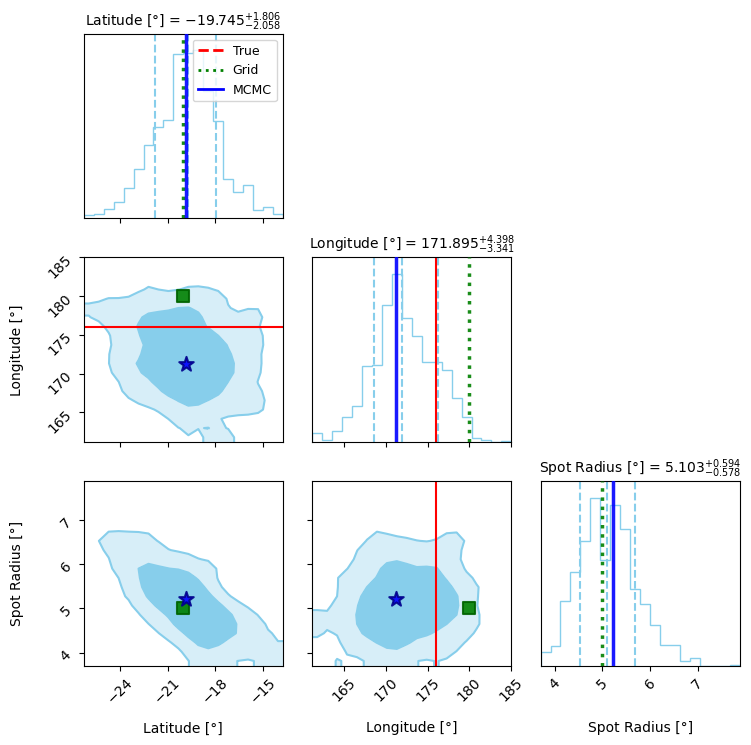

In [24]:
# Your known parameters (fill these with your actual values)
true_params = [16.81, 176, 12.17]  # Replace with actual values
initial_params = [-20, 180, 5]  # Replace with grid search results

# Create the plot - SAME FUNCTION CALL AS BEFORE!
fig, mcmc_best = create_adaptive_corner_plot(
    sampler_data=data,  # Pass your data instead of sampler
    true_params=true_params,
    grid_params=initial_params,
    labels=['Latitude [°]', 'Longitude [°]', 'Spot Radius [°]'],
    save_path='mcmc_results.png'
)

plt.show()

📂 Loading MCMC data from: mcmc_results_20260126_150843.pkl
✅ Data loaded successfully
   Walkers: 20, Steps: 130, Parameters: 3
   Total samples: 2,600
   Acceptance rate: 0.651

📊 MCMC STATS: 130 steps × 20 walkers = 2600 samples
📈 Best log probability: -1577.42

🔍 Best MCMC parameters:
   Latitude [°]: -19.8455
   Longitude [°]: 171.1921
   Spot Radius [°]: 5.2202
📊 Many samples (≥100): Complete corner plot with burn-in...
✅ Plot saved as: mcmc_final_results.png

PARAMETER COMPARISON
Parameter       True         Grid         MCMC (best)  Δ (MCMC-True)
----------------------------------------------------------------------
Latitude [°]    -20.0000     16.8100      -19.8455     +0.1545     
Longitude [°]   172.0000     176.0500     171.1921     -0.8079     
Spot Radius [°] 5.0000       12.1700      5.2202       +0.2202     
📝 Best parameters saved to: mcmc_final_results_best_params.txt


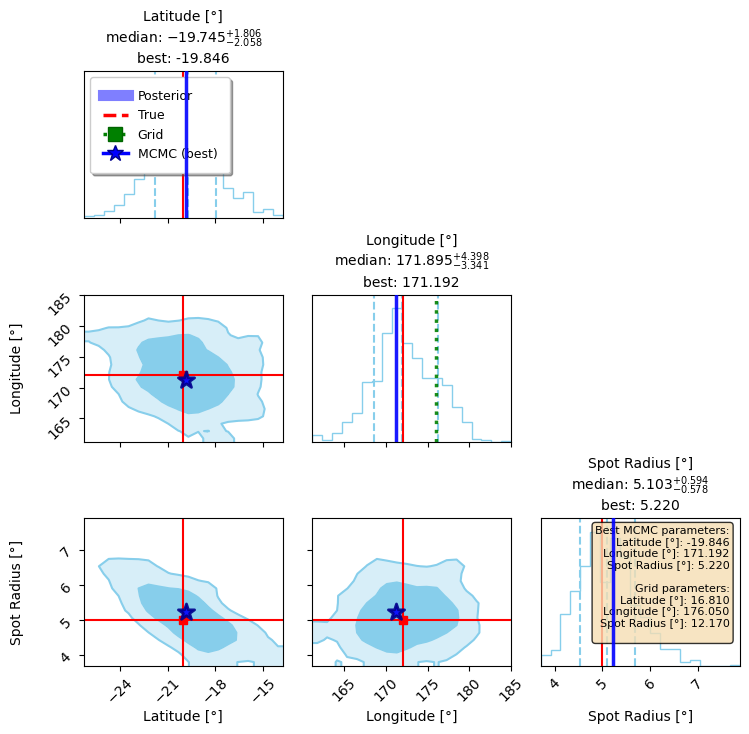


🎯 Best MCMC parameters:
   Latitude [°]: -19.8455
   Longitude [°]: 171.1921
   Spot Radius [°]: 5.2202


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import corner
from matplotlib import gridspec

def create_adaptive_corner_plot(sampler_data, true_params=None, grid_params=None,
                                labels=None, save_path='corner_plot.png'):
    """
    Creates an adaptive corner plot that works for any number of iterations.
    Automatically adjusts: with few samples makes simple plot, with many makes complete corner plot.
    
    Args:
        sampler_data: Dictionary with MCMC results OR sampler object
        true_params: Array with true parameters [lat, lon, radii]
        grid_params: Array with grid search best fit
        labels: List of parameter names (optional)
        save_path: Path to save the plot
    """
    
    # Helper function for simple diagnostic plot
    def create_simple_diagnostic_plot(chain, true_params, grid_params, mcmc_best):
        """Simple plot for when there are few samples"""
        n_steps, n_walkers, n_params = chain.shape
        
        fig = plt.figure(figsize=(15, 4 * n_params))
        
        # For each parameter
        for i in range(n_params):
            # Trace plot
            ax1 = plt.subplot(n_params, 2, 2*i + 1)
            for w in range(min(n_walkers, 5)):  # Show max 5 walkers
                ax1.plot(chain[:, w, i], alpha=0.7, linewidth=0.5)
            
            if true_params is not None:
                ax1.axhline(true_params[i], color='red', linestyle='--', 
                           linewidth=2, label='True', alpha=0.8)
            if grid_params is not None:
                ax1.axhline(grid_params[i], color='green', linestyle=':', 
                           linewidth=2, label='Grid', alpha=0.8)
            if mcmc_best is not None:
                ax1.axhline(mcmc_best[i], color='blue', linestyle='-', 
                           linewidth=2, label='MCMC', alpha=0.8)
            
            param_label = labels[i] if labels else f'Parameter {i}'
            ax1.set_ylabel(param_label)
            ax1.grid(True, alpha=0.3)
            
            if i == 0:
                ax1.legend(loc='upper right')
            
            # Histogram
            ax2 = plt.subplot(n_params, 2, 2*i + 2)
            all_samples = chain[:, :, i].flatten()
            ax2.hist(all_samples, bins=30, density=True, alpha=0.7, 
                    edgecolor='black', color='skyblue')
            
            # Add vertical lines
            line_colors = {'True': 'red', 'Grid': 'green', 'MCMC': 'blue'}
            line_styles = {'True': '--', 'Grid': ':', 'MCMC': '-'}
            
            if true_params is not None:
                ax2.axvline(true_params[i], color=line_colors['True'], 
                          linestyle=line_styles['True'], linewidth=2, alpha=0.8)
            if grid_params is not None:
                ax2.axvline(grid_params[i], color=line_colors['Grid'], 
                          linestyle=line_styles['Grid'], linewidth=2, alpha=0.8)
            if mcmc_best is not None:
                ax2.axvline(mcmc_best[i], color=line_colors['MCMC'], 
                          linestyle=line_styles['MCMC'], linewidth=2, alpha=0.8)
            
            ax2.set_xlabel(param_label)
            ax2.set_ylabel('Density')
            ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig
    
    # Helper function for basic corner plot
    def create_basic_corner(flat_samples, true_params, grid_params, mcmc_best, labels):
        """Basic corner plot for moderate samples"""
        # Use corner.corner with consistent settings
        fig = corner.corner(
            flat_samples,
            labels=labels,
            truths=true_params,
            truth_color='red',
            truth_linestyle='--',
            truth_linewidth=2,
            show_titles=True,
            title_fmt='.3f',
            title_kwargs={"fontsize": 10},
            quantiles=[0.16, 0.5, 0.84],
            verbose=False
        )
        
        # Get the axes to add grid and MCMC best values
        ndim = flat_samples.shape[1]
        axes = np.array(fig.axes).reshape((ndim, ndim))
        
        # Add grid parameters as GREEN SQUARES (not stars)
        if grid_params is not None:
            for i in range(ndim):
                for j in range(ndim):
                    ax = axes[i, j]
                    if i == j:
                        # 1D histograms - vertical line
                        ylim = ax.get_ylim()
                        ax.plot([grid_params[i], grid_params[i]], ylim, 
                               color='green', linestyle=':', linewidth=2.5, 
                               alpha=0.9, zorder=10)
                    elif i > j:
                        # 2D scatter plots - SQUARE marker
                        ax.scatter(grid_params[j], grid_params[i], 
                                  color='green', marker='s', s=80, 
                                  edgecolor='darkgreen', linewidth=1.5,
                                  alpha=0.9, zorder=10, label='Grid' if i==ndim-1 and j==0 else "")
        
        # Add MCMC best parameters as BLUE STARS
        if mcmc_best is not None:
            for i in range(ndim):
                for j in range(ndim):
                    ax = axes[i, j]
                    if i == j:
                        # 1D histograms - vertical line
                        ylim = ax.get_ylim()
                        ax.plot([mcmc_best[i], mcmc_best[i]], ylim, 
                               color='blue', linestyle='-', linewidth=2.5, 
                               alpha=0.9, zorder=11)
                    elif i > j:
                        # 2D scatter plots - STAR marker
                        ax.scatter(mcmc_best[j], mcmc_best[i], 
                                  color='blue', marker='*', s=120, 
                                  edgecolor='darkblue', linewidth=1.5,
                                  alpha=0.9, zorder=11, label='MCMC' if i==ndim-1 and j==0 else "")
        
        # Add clear legend to the first plot
        handles = []
        labels_legend = []
        
        if true_params is not None:
            handles.append(plt.Line2D([], [], color='red', linestyle='--', linewidth=2))
            labels_legend.append('True')
        
        if grid_params is not None:
            # For 2D plots: square marker, for 1D plots: dotted line
            handles.append(plt.Line2D([], [], color='green', linestyle=':', linewidth=2, marker='s',
                                     markersize=8, markeredgecolor='darkgreen'))
            labels_legend.append('Grid')
        
        if mcmc_best is not None:
            # For 2D plots: star marker, for 1D plots: solid line
            handles.append(plt.Line2D([], [], color='blue', linestyle='-', linewidth=2, marker='*',
                                     markersize=10, markeredgecolor='darkblue'))
            labels_legend.append('MCMC')
        
        if handles:
            axes[0, 0].legend(handles, labels_legend, loc='upper right', fontsize=9, 
                             frameon=True, fancybox=True, shadow=True)
        
        return fig
    
    # Helper function for enhanced corner plot
    def create_enhanced_corner(flat_samples, true_params, grid_params, mcmc_best, labels):
        """Enhanced corner plot with burn-in discarded"""
        # Create the corner plot with more customization
        fig = corner.corner(
            flat_samples,
            labels=labels,
            truths=true_params,
            truth_color='red',
            truth_linestyle='--',
            truth_linewidth=2.5,
            show_titles=True,
            title_fmt='.3f',
            title_kwargs={"fontsize": 10},
            quantiles=[0.16, 0.5, 0.84],
            levels=[0.68, 0.95],
            plot_density=True,
            plot_datapoints=False,
            fill_contours=True,
            smooth=1.0,
            color='skyblue',
            alpha=0.5,
            verbose=False
        )
        
        # Get axes for additional annotations
        ndim = flat_samples.shape[1]
        axes = np.array(fig.axes).reshape((ndim, ndim))
        
        # Add grid parameters as GREEN SQUARES
        if grid_params is not None:
            for i in range(ndim):
                for j in range(ndim):
                    ax = axes[i, j]
                    if i == j:
                        # 1D histograms - vertical dotted line
                        ylim = ax.get_ylim()
                        ax.plot([grid_params[i], grid_params[i]], ylim, 
                               color='green', linestyle=':', linewidth=2.5, 
                               alpha=0.9, zorder=10)
                    elif i > j:
                        # 2D scatter plots - SQUARE marker
                        ax.scatter(grid_params[j], grid_params[i], 
                                  color='green', marker='s', s=100, 
                                  edgecolor='darkgreen', linewidth=2,
                                  alpha=0.9, zorder=10, label='Grid' if i==ndim-1 and j==0 else "")
        
        # Add MCMC best parameters as BLUE STARS
        if mcmc_best is not None:
            for i in range(ndim):
                for j in range(ndim):
                    ax = axes[i, j]
                    if i == j:
                        # 1D histograms - vertical solid line
                        ylim = ax.get_ylim()
                        ax.plot([mcmc_best[i], mcmc_best[i]], ylim, 
                               color='blue', linestyle='-', linewidth=2.5, 
                               alpha=0.9, zorder=11)
                    elif i > j:
                        # 2D scatter plots - STAR marker
                        ax.scatter(mcmc_best[j], mcmc_best[i], 
                                  color='blue', marker='*', s=150, 
                                  edgecolor='darkblue', linewidth=2,
                                  alpha=0.9, zorder=11, label='MCMC' if i==ndim-1 and j==0 else "")
        
        # Add BEST PARAMETER VALUES as text annotations
        if mcmc_best is not None:
            for i in range(ndim):
                ax = axes[i, i]  # Diagonal plots
                
                # Get current title
                current_title = ax.get_title()
                
                # Add best parameter value to title
                param_name = labels[i] if labels else f'Parameter {i}'
                best_value = mcmc_best[i]
                
                # Format: "Param Name = median +up/-down (best = X.XXX)"
                if '=' in current_title:
                    # Extract median value from existing title
                    parts = current_title.split('=')
                    if len(parts) > 1:
                        median_part = parts[1].strip()
                        # Add best parameter info
                        new_title = f"{param_name}\nmedian: {median_part}\nbest: {best_value:.3f}"
                        ax.set_title(new_title, fontsize=10)
        
        # Add comprehensive legend
        legend_elements = []
        
        # Posterior distribution
        legend_elements.append(plt.Line2D([], [], color='blue', alpha=0.5, linewidth=8))
        
        # True parameters (red dashed line)
        if true_params is not None:
            legend_elements.append(plt.Line2D([], [], color='red', linestyle='--', linewidth=2.5))
        
        # Grid parameters (green square + dotted line)
        if grid_params is not None:
            # Combined element showing both line and marker
            legend_elements.append(plt.Line2D([], [], color='green', linestyle=':', linewidth=2.5,
                                             marker='s', markersize=10, markeredgecolor='darkgreen'))
        
        # MCMC best parameters (blue star + solid line)
        if mcmc_best is not None:
            legend_elements.append(plt.Line2D([], [], color='blue', linestyle='-', linewidth=2.5,
                                             marker='*', markersize=12, markeredgecolor='darkblue'))
        
        # Legend labels
        legend_labels = ['Posterior']
        if true_params is not None:
            legend_labels.append('True')
        if grid_params is not None:
            legend_labels.append('Grid')
        if mcmc_best is not None:
            legend_labels.append('MCMC (best)')
        
        # Add legend to first subplot
        axes[0, 0].legend(legend_elements, legend_labels, 
                         loc='upper left', fontsize=9,
                         frameon=True, fancybox=True, 
                         shadow=True, borderpad=1)
        
        # Add summary box with best parameters
        summary_text = "Best MCMC parameters:\n"
        for i in range(ndim):
            param_name = labels[i] if labels else f'Param {i}'
            best_val = mcmc_best[i] if mcmc_best is not None else np.nan
            summary_text += f"{param_name}: {best_val:.3f}\n"
        
        if grid_params is not None:
            summary_text += "\nGrid parameters:\n"
            for i in range(ndim):
                param_name = labels[i] if labels else f'Param {i}'
                grid_val = grid_params[i]
                summary_text += f"{param_name}: {grid_val:.3f}\n"
        
        # Add text box in last subplot
        axes[-1, -1].text(0.95, 0.95, summary_text,
                         transform=axes[-1, -1].transAxes,
                         fontsize=8, verticalalignment='top',
                         horizontalalignment='right',
                         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        return fig
    
    # MAIN FUNCTION LOGIC STARTS HERE
    
    # 1. Get the chains from MCMC data
    if isinstance(sampler_data, dict):
        # Use your saved data structure
        chain = sampler_data['sampler_chain']
        
        # Transpose to match emcee format: [steps, walkers, params]
        # Your data is [walkers, steps, params], so we need to transpose
        chain = np.transpose(chain, (1, 0, 2))
        
        # Get log probability if available
        if 'sampler_lnprobability' in sampler_data:
            log_prob = sampler_data['sampler_lnprobability']
            # Transpose if needed
            if log_prob.shape[0] == chain.shape[1]:  # [walkers, steps]
                log_prob = np.transpose(log_prob, (1, 0))  # to [steps, walkers]
        else:
            log_prob = None
        
        # Get flat samples
        flat_samples = sampler_data['flat_chain']
        
        # Get best parameters from saved data
        if 'best_params' in sampler_data:
            mcmc_best = sampler_data['best_params']
            best_lnprob = sampler_data.get('best_lnprob', None)
        else:
            mcmc_best = None
            best_lnprob = None
        
    else:
        # Original emcee sampler object logic
        try:
            chain = sampler_data.get_chain()  # emcee v3
            log_prob = sampler_data.get_log_prob()
        except AttributeError:
            chain = sampler_data.chain  # emcee v2
            log_prob = getattr(sampler_data, 'lnprobability', None)
        
        flat_samples = chain.reshape(-1, chain.shape[2])
        
        # Calculate best parameters
        if log_prob is not None:
            best_idx = np.unravel_index(np.argmax(log_prob), log_prob.shape)
            mcmc_best = chain[best_idx]
            best_lnprob = log_prob[best_idx]
        else:
            mcmc_best = np.median(flat_samples, axis=0)
            best_lnprob = None
    
    n_steps, n_walkers, n_params = chain.shape
    total_samples = n_steps * n_walkers
    
    print(f"\n📊 MCMC STATS: {n_steps} steps × {n_walkers} walkers = {total_samples} samples")
    if best_lnprob is not None:
        print(f"📈 Best log probability: {best_lnprob:.2f}")
    
    # 2. Determine the best MCMC parameter (if not already set)
    if mcmc_best is None:
        if log_prob is not None:
            # Find maximum log probability
            best_idx = np.unravel_index(np.argmax(log_prob), log_prob.shape)
            mcmc_best = chain[best_idx]
        else:
            # Fallback: use median of all samples
            mcmc_best = np.median(flat_samples, axis=0)
    
    # 3. DECISION: What type of plot to make?
    # Use default labels if not provided
    if labels is None:
        if isinstance(sampler_data, dict) and 'labels' in sampler_data:
            labels = sampler_data['labels']
        else:
            labels = ['Latitude [°]', 'Longitude [°]', 'Spot Radius [°]']
    
    # Ensure labels match parameter count
    if len(labels) > n_params:
        labels = labels[:n_params]
    elif len(labels) < n_params:
        labels = labels + [f'Parameter {i}' for i in range(len(labels), n_params)]
    
    print(f"\n🔍 Best MCMC parameters:")
    for i, (label, value) in enumerate(zip(labels, mcmc_best)):
        print(f"   {label}: {value:.4f}")
    
    if total_samples < 50:
        print("🔍 Few samples (<50): Creating diagnostic plot...")
        fig = create_simple_diagnostic_plot(chain, true_params, grid_params, mcmc_best)
        
    elif total_samples < 100:
        print("📈 Moderate samples (50-100): Corner plot with all samples...")
        # Use all samples without discarding
        fig = create_basic_corner(flat_samples, true_params, grid_params, mcmc_best, labels)
        
    else:
        print("📊 Many samples (≥100): Complete corner plot with burn-in...")
        # Discard burn-in (first 20% or 50 steps, whichever is smaller)
        discard = min(50, int(0.2 * n_steps))
        remaining = n_steps - discard
        
        if remaining > 0:
            # Thin if there are many samples
            thin = max(1, int(remaining / 50))  # We want ~50 points per walker
            if isinstance(sampler_data, dict):
                # For saved data, manually discard and thin
                chain_burned = chain[discard:, :, :]
                if thin > 1:
                    chain_burned = chain_burned[::thin, :, :]
                flat_samples = chain_burned.reshape(-1, n_params)
            else:
                # For sampler object, use emcee's method
                flat_samples = sampler_data.get_chain(discard=discard, thin=thin, flat=True)
        else:
            # If discard leaves 0 steps, use everything
            flat_samples = flat_samples
        
        fig = create_enhanced_corner(flat_samples, true_params, grid_params, mcmc_best, labels)
    
    # 4. Save and display
    plt.tight_layout()
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Plot saved as: {save_path}")
    
    # 5. Print parameter comparison
    print("\n" + "="*60)
    print("PARAMETER COMPARISON")
    print("="*60)
    print(f"{'Parameter':<15} {'True':<12} {'Grid':<12} {'MCMC (best)':<12} {'Δ (MCMC-True)':<12}")
    print("-"*70)
    
    for i, name in enumerate(labels[:n_params]):
        true_val = true_params[i] if true_params is not None else np.nan
        grid_val = grid_params[i] if grid_params is not None else np.nan
        mcmc_val = mcmc_best[i]
        delta = mcmc_val - true_val if true_params is not None else np.nan
        
        true_str = f"{true_val:.4f}" if true_params is not None else "N/A"
        grid_str = f"{grid_val:.4f}" if grid_params is not None else "N/A"
        delta_str = f"{delta:+.4f}" if true_params is not None else "N/A"
        
        print(f"{name:<15} {true_str:<12} {grid_str:<12} {mcmc_val:<12.4f} {delta_str:<12}")
    
    # 6. Also create a separate text file with best parameters
    if isinstance(sampler_data, dict) and 'best_lnprob' in sampler_data:
        txt_path = save_path.replace('.png', '_best_params.txt')
        with open(txt_path, 'w') as f:
            f.write("="*60 + "\n")
            f.write("MCMC BEST PARAMETERS SUMMARY\n")
            f.write("="*60 + "\n\n")
            f.write(f"Total samples: {total_samples:,}\n")
            f.write(f"Best log probability: {best_lnprob:.4f}\n\n")
            
            f.write("Parameter estimates:\n")
            f.write("-"*50 + "\n")
            for i, label in enumerate(labels[:n_params]):
                f.write(f"{label}: {mcmc_best[i]:.6f}\n")
            
            if true_params is not None:
                f.write("\nComparison with true values:\n")
                f.write("-"*50 + "\n")
                for i, label in enumerate(labels[:n_params]):
                    delta = mcmc_best[i] - true_params[i]
                    percent_error = abs(delta / true_params[i]) * 100 if true_params[i] != 0 else np.nan
                    f.write(f"{label}: True={true_params[i]:.6f}, MCMC={mcmc_best[i]:.6f}, "
                           f"Δ={delta:+.6f} ({percent_error:.2f}%)\n")
            
            if grid_params is not None:
                f.write("\nComparison with grid search:\n")
                f.write("-"*50 + "\n")
                for i, label in enumerate(labels[:n_params]):
                    delta = mcmc_best[i] - grid_params[i]
                    f.write(f"{label}: Grid={grid_params[i]:.6f}, MCMC={mcmc_best[i]:.6f}, "
                           f"Δ={delta:+.6f}\n")
        
        print(f"📝 Best parameters saved to: {txt_path}")
    
    return fig, mcmc_best


# SHORTCUT FUNCTION FOR YOUR SPECIFIC USE CASE
def plot_mcmc_results(data_file='mcmc_results_20260126_150843.pkl',
                      true_params=None, grid_params=None,
                      labels=['Latitude [°]', 'Longitude [°]', 'Spot Radius [°]'],
                      output_file='mcmc_corner_plot.png'):
    """
    Convenience function to load data and create corner plot
    """
    import pickle
    
    print(f"📂 Loading MCMC data from: {data_file}")
    with open(data_file, 'rb') as f:
        data = pickle.load(f)
    
    print("✅ Data loaded successfully")
    
    # Print basic info
    chain = data['sampler_chain']
    n_walkers, n_steps, n_params = chain.shape
    print(f"   Walkers: {n_walkers}, Steps: {n_steps}, Parameters: {n_params}")
    print(f"   Total samples: {n_walkers * n_steps:,}")
    print(f"   Acceptance rate: {np.mean(data['acceptance_fraction']):.3f}")
    
    # Create the plot
    fig, mcmc_best = create_adaptive_corner_plot(
        sampler_data=data,
        true_params=true_params,
        grid_params=grid_params,
        labels=labels,
        save_path=output_file
    )
    
    plt.show()
    
    return fig, mcmc_best, data


# EXAMPLE USAGE
if __name__ == "__main__":
    # Your actual parameters (replace with your values)
    true_params_example = [-20.0, 172.0, 5.0]  # Based on your output
    grid_params_example = [16.81, 176.05, 12.17]  # Example grid search results
    
    # Create the plot
    fig, mcmc_best, data = plot_mcmc_results(
        data_file='mcmc_results_20260126_150843.pkl',
        true_params=true_params_example,
        grid_params=grid_params_example,
        labels=['Latitude [°]', 'Longitude [°]', 'Spot Radius [°]'],
        output_file='mcmc_final_results.png'
    )
    
    print(f"\n🎯 Best MCMC parameters:")
    for i, label in enumerate(['Latitude [°]', 'Longitude [°]', 'Spot Radius [°]']):
        print(f"   {label}: {mcmc_best[i]:.4f}")


📊 MCMC STATS: 130 steps × 20 walkers = 2600 samples
📈 Best log probability: -1577.42

🔍 Best MCMC parameters:
   Latitude [°]: -19.8455
   Longitude [°]: 171.1921
   Spot Radius [°]: 5.2202
📊 Many samples (≥100): Complete corner plot with burn-in...
✅ Plot saved as: mcmc_results_with_external_legend.png

PARAMETER COMPARISON
Parameter       True         Grid         MCMC (best)  Δ (MCMC-True)
----------------------------------------------------------------------
Latitude [°]    16.8100      -20.0000     -19.8455     -36.6555    
Longitude [°]   176.0000     180.0000     171.1921     -4.8079     
Spot Radius [°] 12.0000      5.0000       5.2202       -6.7798     
📝 Best parameters saved to: mcmc_results_with_external_legend_best_params.txt


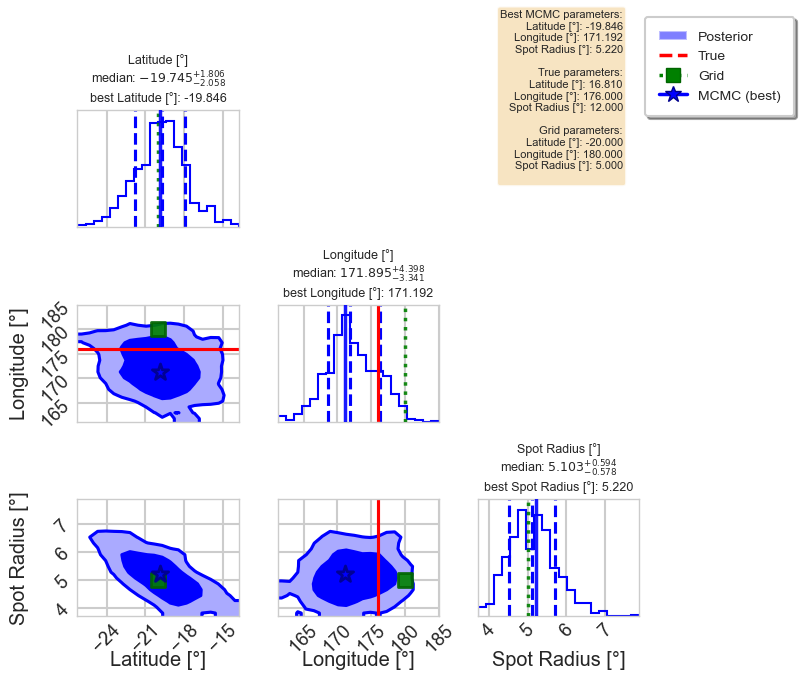


✅ Best parameters:
   Latitude: -19.8455°
   Longitude: 171.1921°
   Spot Radius: 5.2202°


In [68]:
import numpy as np
import matplotlib.pyplot as plt
import corner
from matplotlib import gridspec

def create_adaptive_corner_plot(sampler_data, true_params=None, grid_params=None,
                                labels=None, save_path='corner_plot.png'):
    """
    Creates an adaptive corner plot that works for any number of iterations.
    Automatically adjusts: with few samples makes simple plot, with many makes complete corner plot.
    
    Args:
        sampler_data: Dictionary with MCMC results OR sampler object
        true_params: Array with true parameters [lat, lon, radii]
        grid_params: Array with grid search best fit
        labels: List of parameter names (optional)
        save_path: Path to save the plot
    """
    
    # Helper function for simple diagnostic plot
    def create_simple_diagnostic_plot(chain, true_params, grid_params, mcmc_best):
        """Simple plot for when there are few samples"""
        n_steps, n_walkers, n_params = chain.shape
        
        fig = plt.figure(figsize=(15, 4 * n_params))
        
        # For each parameter
        for i in range(n_params):
            # Trace plot
            ax1 = plt.subplot(n_params, 2, 2*i + 1)
            for w in range(min(n_walkers, 5)):  # Show max 5 walkers
                ax1.plot(chain[:, w, i], alpha=0.7, linewidth=0.5)
            
            if true_params is not None:
                ax1.axhline(true_params[i], color='red', linestyle='--', 
                           linewidth=2, label='True', alpha=0.8)
            if grid_params is not None:
                ax1.axhline(grid_params[i], color='green', linestyle=':', 
                           linewidth=2, label='Grid', alpha=0.8)
            if mcmc_best is not None:
                ax1.axhline(mcmc_best[i], color='blue', linestyle='-', 
                           linewidth=2, label='MCMC', alpha=0.8)
            
            param_label = labels[i] if labels else f'Parameter {i}'
            ax1.set_ylabel(param_label)
            ax1.grid(True, alpha=0.3)
            
            if i == 0:
                ax1.legend(loc='upper right')
            
            # Histogram
            ax2 = plt.subplot(n_params, 2, 2*i + 2)
            all_samples = chain[:, :, i].flatten()
            ax2.hist(all_samples, bins=30, density=True, alpha=0.7, 
                    edgecolor='black', color='skyblue')
            
            # Add vertical lines
            line_colors = {'True': 'red', 'Grid': 'green', 'MCMC': 'blue'}
            line_styles = {'True': '--', 'Grid': ':', 'MCMC': '-'}
            
            if true_params is not None:
                ax2.axvline(true_params[i], color=line_colors['True'], 
                          linestyle=line_styles['True'], linewidth=2, alpha=0.8)
            if grid_params is not None:
                ax2.axvline(grid_params[i], color=line_colors['Grid'], 
                          linestyle=line_styles['Grid'], linewidth=2, alpha=0.8)
            if mcmc_best is not None:
                ax2.axvline(mcmc_best[i], color=line_colors['MCMC'], 
                          linestyle=line_styles['MCMC'], linewidth=2, alpha=0.8)
            
            ax2.set_xlabel(param_label)
            ax2.set_ylabel('Density')
            ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig
    
    # Helper function for basic corner plot
    def create_basic_corner(flat_samples, true_params, grid_params, mcmc_best, labels):
        """Basic corner plot for moderate samples"""
        # Use corner.corner with consistent settings
        fig = corner.corner(
            flat_samples,
            labels=labels,
            truths=true_params,
            truth_color='red',
            truth_linestyle='--',
            truth_linewidth=2,
            show_titles=True,
            title_fmt='.3f',
            title_kwargs={"fontsize": 10},
            quantiles=[0.16, 0.5, 0.84],
            verbose=False
        )
        
        # Get the axes to add grid and MCMC best values
        ndim = flat_samples.shape[1]
        axes = np.array(fig.axes).reshape((ndim, ndim))
        
        # Add grid parameters as GREEN SQUARES (not stars)
        if grid_params is not None:
            for i in range(ndim):
                for j in range(ndim):
                    ax = axes[i, j]
                    if i == j:
                        # 1D histograms - vertical line
                        ylim = ax.get_ylim()
                        ax.plot([grid_params[i], grid_params[i]], ylim, 
                               color='green', linestyle=':', linewidth=2.5, 
                               alpha=0.9, zorder=10)
                    elif i > j:
                        # 2D scatter plots - SQUARE marker
                        ax.scatter(grid_params[j], grid_params[i], 
                                  color='green', marker='s', s=80, 
                                  edgecolor='darkgreen', linewidth=1.5,
                                  alpha=0.9, zorder=10)
        
        # Add MCMC best parameters as BLUE STARS
        if mcmc_best is not None:
            for i in range(ndim):
                for j in range(ndim):
                    ax = axes[i, j]
                    if i == j:
                        # 1D histograms - vertical line
                        ylim = ax.get_ylim()
                        ax.plot([mcmc_best[i], mcmc_best[i]], ylim, 
                               color='blue', linestyle='-', linewidth=2.5, 
                               alpha=0.9, zorder=11)
                    elif i > j:
                        # 2D scatter plots - STAR marker
                        ax.scatter(mcmc_best[j], mcmc_best[i], 
                                  color='blue', marker='*', s=120, 
                                  edgecolor='darkblue', linewidth=1.5,
                                  alpha=0.9, zorder=11)
        
        # Create legend OUTSIDE the corner plot
        legend_elements = []
        legend_labels = []
        
        # Add posterior distribution patch (for legend only)
        legend_elements.append(plt.Rectangle((0, 0), 1, 1, facecolor='blue', alpha=0.5))
        legend_labels.append('Posterior')
        
        if true_params is not None:
            legend_elements.append(plt.Line2D([], [], color='red', linestyle='--', linewidth=2.5))
            legend_labels.append('True')
        
        if grid_params is not None:
            # For legend: show both line style and marker
            legend_elements.append(plt.Line2D([], [], color='green', linestyle=':', linewidth=2.5,
                                             marker='s', markersize=8, markeredgecolor='darkgreen'))
            legend_labels.append('Grid')
        
        if mcmc_best is not None:
            legend_elements.append(plt.Line2D([], [], color='blue', linestyle='-', linewidth=2.5,
                                             marker='*', markersize=10, markeredgecolor='darkblue'))
            legend_labels.append('MCMC (best)')
        
        # Add legend to the FIGURE (outside the corner plot)
        fig.legend(legend_elements, legend_labels, 
                  loc='upper left', bbox_to_anchor=(0.05, 0.95),
                  fontsize=10, frameon=True, fancybox=True, 
                  shadow=True, borderpad=1, handlelength=2)
        
        return fig
    
    # Helper function for enhanced corner plot
    def create_enhanced_corner(flat_samples, true_params, grid_params, mcmc_best, labels):
        """Enhanced corner plot with burn-in discarded"""
        # Create the corner plot with more customization
        fig = corner.corner(
            flat_samples,
            labels=labels,
            truths=true_params,
            truth_color='red',
            truth_linestyle='--',
            truth_linewidth=2.5,
            show_titles=True,
            title_fmt='.3f',
            title_kwargs={"fontsize": 10},
            quantiles=[0.16, 0.5, 0.84],
            levels=[0.68, 0.95],
            plot_density=True,
            plot_datapoints=False,
            fill_contours=True,
            smooth=1.0,
            color='blue',
            alpha=0.5,
            verbose=False
        )
        
        # Get axes for additional annotations
        ndim = flat_samples.shape[1]
        axes = np.array(fig.axes).reshape((ndim, ndim))
        
        # Add grid parameters as GREEN SQUARES
        if grid_params is not None:
            for i in range(ndim):
                for j in range(ndim):
                    ax = axes[i, j]
                    if i == j:
                        # 1D histograms - vertical dotted line
                        ylim = ax.get_ylim()
                        ax.plot([grid_params[i], grid_params[i]], ylim, 
                               color='green', linestyle=':', linewidth=2.5, 
                               alpha=0.9, zorder=10)
                    elif i > j:
                        # 2D scatter plots - SQUARE marker
                        ax.scatter(grid_params[j], grid_params[i], 
                                  color='green', marker='s', s=100, 
                                  edgecolor='darkgreen', linewidth=2,
                                  alpha=0.9, zorder=10)
        
        # Add MCMC best parameters as BLUE STARS
        if mcmc_best is not None:
            for i in range(ndim):
                for j in range(ndim):
                    ax = axes[i, j]
                    if i == j:
                        # 1D histograms - vertical solid line
                        ylim = ax.get_ylim()
                        ax.plot([mcmc_best[i], mcmc_best[i]], ylim, 
                               color='blue', linestyle='-', linewidth=2.5, 
                               alpha=0.9, zorder=11)
                    elif i > j:
                        # 2D scatter plots - STAR marker
                        ax.scatter(mcmc_best[j], mcmc_best[i], 
                                  color='blue', marker='*', s=150, 
                                  edgecolor='darkblue', linewidth=2,
                                  alpha=0.9, zorder=11)
        
        # Add BEST PARAMETER VALUES as text annotations
        if mcmc_best is not None:
            for i in range(ndim):
                ax = axes[i, i]  # Diagonal plots
                
                # Get current title
                current_title = ax.get_title()
                
                # Add best parameter value to title
                param_name = labels[i] if labels else f'Parameter {i}'
                best_value = mcmc_best[i]
                
                # Format: "Param Name = median +up/-down (best = X.XXX)"
                if '=' in current_title:
                    # Extract median value from existing title
                    parts = current_title.split('=')
                    if len(parts) > 1:
                        median_part = parts[1].strip()
                        # Add best parameter info
                        new_title = f"{param_name}\nmedian: {median_part}\nbest {param_name}: {best_value:.3f}"
                        ax.set_title(new_title, fontsize=9)
        
        # Create legend OUTSIDE the corner plot
        legend_elements = []
        legend_labels = []
        
        # Posterior distribution (filled contours)
        legend_elements.append(plt.Rectangle((0, 0), 1, 1, facecolor='blue', alpha=0.5))
        legend_labels.append('Posterior')
        
        # True parameters (red dashed line)
        if true_params is not None:
            legend_elements.append(plt.Line2D([], [], color='red', linestyle='--', linewidth=2.5))
            legend_labels.append('True')
        
        # Grid parameters (green square + dotted line)
        if grid_params is not None:
            # Combined element showing both line and marker
            legend_elements.append(plt.Line2D([], [], color='green', linestyle=':', linewidth=2.5,
                                             marker='s', markersize=10, markeredgecolor='darkgreen',
                                             markerfacecolor='green'))
            legend_labels.append('Grid')
        
        # MCMC best parameters (blue star + solid line)
        if mcmc_best is not None:
            legend_elements.append(plt.Line2D([], [], color='blue', linestyle='-', linewidth=2.5,
                                             marker='*', markersize=12, markeredgecolor='darkblue',
                                             markerfacecolor='blue'))
            legend_labels.append('MCMC (best)')
        
                # Add legend to the FIGURE (outside, upper left corner)
        # Add legend to the FIGURE (outside, upper left corner)
        fig.legend(legend_elements, legend_labels, 
                  loc='upper left', 
                  bbox_to_anchor=(0.92, 0.98),  # ESQUINA SUPERIOR IZQUIERDA
                  fontsize=10, frameon=True, fancybox=True, 
                  shadow=True, borderpad=1, handlelength=2)
        
        # Add summary box with best parameters (in the last subplot)
        if mcmc_best is not None:
            summary_text = "Best MCMC parameters:\n"
            for i in range(ndim):
                param_name = labels[i] if labels else f'Param {i}'
                best_val = mcmc_best[i]
                summary_text += f"{param_name}: {best_val:.3f}\n"
            
            if true_params is not None:  # ¡FALTABA ESTO!
                summary_text += "\nTrue parameters:\n"
                for i in range(ndim):
                    param_name = labels[i] if labels else f'Param {i}'
                    true_val = true_params[i]
                    summary_text += f"{param_name}: {true_val:.3f}\n"
            
            if grid_params is not None:
                summary_text += "\nGrid parameters:\n"
                for i in range(ndim):
                    param_name = labels[i] if labels else f'Param {i}'
                    grid_val = grid_params[i]
                    summary_text += f"{param_name}: {grid_val:.3f}\n"
            
            # Usar fig.text en lugar de axes.text
            fig.text(0.90, 0.98, summary_text,  # 85% derecha, 95% arriba - ESQUINA SUPERIOR DERECHA
                     fontsize=8, verticalalignment='top',
                     horizontalalignment='right',
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        return fig
    
    # MAIN FUNCTION LOGIC STARTS HERE
    
    # 1. Get the chains from MCMC data
    if isinstance(sampler_data, dict):
        # Use your saved data structure
        chain = sampler_data['sampler_chain']
        
        # Transpose to match emcee format: [steps, walkers, params]
        # Your data is [walkers, steps, params], so we need to transpose
        chain = np.transpose(chain, (1, 0, 2))
        
        # Get log probability if available
        if 'sampler_lnprobability' in sampler_data:
            log_prob = sampler_data['sampler_lnprobability']
            # Transpose if needed
            if log_prob.shape[0] == chain.shape[1]:  # [walkers, steps]
                log_prob = np.transpose(log_prob, (1, 0))  # to [steps, walkers]
        else:
            log_prob = None
        
        # Get flat samples
        flat_samples = sampler_data['flat_chain']
        
        # Get best parameters from saved data
        if 'best_params' in sampler_data:
            mcmc_best = sampler_data['best_params']
            best_lnprob = sampler_data.get('best_lnprob', None)
        else:
            mcmc_best = None
            best_lnprob = None
        
    else:
        # Original emcee sampler object logic
        try:
            chain = sampler_data.get_chain()  # emcee v3
            log_prob = sampler_data.get_log_prob()
        except AttributeError:
            chain = sampler_data.chain  # emcee v2
            log_prob = getattr(sampler_data, 'lnprobability', None)
        
        flat_samples = chain.reshape(-1, chain.shape[2])
        
        # Calculate best parameters
        if log_prob is not None:
            best_idx = np.unravel_index(np.argmax(log_prob), log_prob.shape)
            mcmc_best = chain[best_idx]
            best_lnprob = log_prob[best_idx]
        else:
            mcmc_best = np.median(flat_samples, axis=0)
            best_lnprob = None
    
    n_steps, n_walkers, n_params = chain.shape
    total_samples = n_steps * n_walkers
    
    print(f"\n📊 MCMC STATS: {n_steps} steps × {n_walkers} walkers = {total_samples} samples")
    if best_lnprob is not None:
        print(f"📈 Best log probability: {best_lnprob:.2f}")
    
    # 2. Determine the best MCMC parameter (if not already set)
    if mcmc_best is None:
        if log_prob is not None:
            # Find maximum log probability
            best_idx = np.unravel_index(np.argmax(log_prob), log_prob.shape)
            mcmc_best = chain[best_idx]
        else:
            # Fallback: use median of all samples
            mcmc_best = np.median(flat_samples, axis=0)
    
    # 3. DECISION: What type of plot to make?
    # Use default labels if not provided
    if labels is None:
        if isinstance(sampler_data, dict) and 'labels' in sampler_data:
            labels = sampler_data['labels']
        else:
            labels = ['Latitude [°]', 'Longitude [°]', 'Spot Radius [°]']
    
    # Ensure labels match parameter count
    if len(labels) > n_params:
        labels = labels[:n_params]
    elif len(labels) < n_params:
        labels = labels + [f'Parameter {i}' for i in range(len(labels), n_params)]
    
    print(f"\n🔍 Best MCMC parameters:")
    for i, (label, value) in enumerate(zip(labels, mcmc_best)):
        print(f"   {label}: {value:.4f}")
    
    if total_samples < 50:
        print("🔍 Few samples (<50): Creating diagnostic plot...")
        fig = create_simple_diagnostic_plot(chain, true_params, grid_params, mcmc_best)
        
    elif total_samples < 100:
        print("📈 Moderate samples (50-100): Corner plot with all samples...")
        # Use all samples without discarding
        fig = create_basic_corner(flat_samples, true_params, grid_params, mcmc_best, labels)
        
    else:
        print("📊 Many samples (≥100): Complete corner plot with burn-in...")
        # Discard burn-in (first 20% or 50 steps, whichever is smaller)
        discard = min(50, int(0.2 * n_steps))
        remaining = n_steps - discard
        
        if remaining > 0:
            # Thin if there are many samples
            thin = max(1, int(remaining / 50))  # We want ~50 points per walker
            if isinstance(sampler_data, dict):
                # For saved data, manually discard and thin
                chain_burned = chain[discard:, :, :]
                if thin > 1:
                    chain_burned = chain_burned[::thin, :, :]
                flat_samples = chain_burned.reshape(-1, n_params)
            else:
                # For sampler object, use emcee's method
                flat_samples = sampler_data.get_chain(discard=discard, thin=thin, flat=True)
        else:
            # If discard leaves 0 steps, use everything
            flat_samples = flat_samples
        
        fig = create_enhanced_corner(flat_samples, true_params, grid_params, mcmc_best, labels)
    
    # 4. Adjust layout to make space for the external legend
    plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])  # Leave space at top for legend
    
    # 5. Save and display
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Plot saved as: {save_path}")
    
    # 6. Print parameter comparison
    print("\n" + "="*60)
    print("PARAMETER COMPARISON")
    print("="*60)
    print(f"{'Parameter':<15} {'True':<12} {'Grid':<12} {'MCMC (best)':<12} {'Δ (MCMC-True)':<12}")
    print("-"*70)
    
    for i, name in enumerate(labels[:n_params]):
        true_val = true_params[i] if true_params is not None else np.nan
        grid_val = grid_params[i] if grid_params is not None else np.nan
        mcmc_val = mcmc_best[i]
        delta = mcmc_val - true_val if true_params is not None else np.nan
        
        true_str = f"{true_val:.4f}" if true_params is not None else "N/A"
        grid_str = f"{grid_val:.4f}" if grid_params is not None else "N/A"
        delta_str = f"{delta:+.4f}" if true_params is not None else "N/A"
        
        print(f"{name:<15} {true_str:<12} {grid_str:<12} {mcmc_val:<12.4f} {delta_str:<12}")
    
    # 7. Also create a separate text file with best parameters
    if isinstance(sampler_data, dict) and 'best_lnprob' in sampler_data:
        txt_path = save_path.replace('.png', '_best_params.txt')
        with open(txt_path, 'w') as f:
            f.write("="*60 + "\n")
            f.write("MCMC BEST PARAMETERS SUMMARY\n")
            f.write("="*60 + "\n\n")
            f.write(f"Total samples: {total_samples:,}\n")
            f.write(f"Best log probability: {best_lnprob:.4f}\n\n")
            
            f.write("Parameter estimates:\n")
            f.write("-"*50 + "\n")
            for i, label in enumerate(labels[:n_params]):
                f.write(f"{label}: {mcmc_best[i]:.6f}\n")
            
            if true_params is not None:
                f.write("\nComparison with true values:\n")
                f.write("-"*50 + "\n")
                for i, label in enumerate(labels[:n_params]):
                    delta = mcmc_best[i] - true_params[i]
                    percent_error = abs(delta / true_params[i]) * 100 if true_params[i] != 0 else np.nan
                    f.write(f"{label}: True={true_params[i]:.6f}, MCMC={mcmc_best[i]:.6f}, "
                           f"Δ={delta:+.6f} ({percent_error:.2f}%)\n")
            
            if grid_params is not None:
                f.write("\nComparison with grid search:\n")
                f.write("-"*50 + "\n")
                for i, label in enumerate(labels[:n_params]):
                    delta = mcmc_best[i] - grid_params[i]
                    f.write(f"{label}: Grid={grid_params[i]:.6f}, MCMC={mcmc_best[i]:.6f}, "
                           f"Δ={delta:+.6f}\n")
        
        print(f"📝 Best parameters saved to: {txt_path}")
    
    return fig, mcmc_best


# VERSIÓN MEJORADA CON LEYENDA EXTERNA MÁS CLARA
def create_adaptive_corner_plot_external_legend(sampler_data, true_params=None, grid_params=None,
                                                labels=None, save_path='corner_plot.png'):
    """
    Same as above but with external legend placed better
    """
    # Call the main function
    fig, mcmc_best = create_adaptive_corner_plot(sampler_data, true_params, grid_params, 
                                                 labels, save_path)
    
    # Add external legend if not already added (for backward compatibility)
    if len(fig.legends) == 0:
        ndim = sampler_data['flat_chain'].shape[1] if isinstance(sampler_data, dict) else 3
        
        # Create custom legend
        legend_elements = []
        legend_labels = []
        
        # Posterior distribution
        legend_elements.append(plt.Rectangle((0, 0), 1, 1, facecolor='blue', alpha=0.5))
        legend_labels.append('Posterior')
        
        if true_params is not None:
            legend_elements.append(plt.Line2D([], [], color='red', linestyle='--', linewidth=2))
            legend_labels.append('True')
        
        if grid_params is not None:
            legend_elements.append(plt.Line2D([], [], color='green', linestyle=':', linewidth=2,
                                             marker='s', markersize=8, markeredgecolor='darkgreen'))
            legend_labels.append('Grid')
        
        legend_elements.append(plt.Line2D([], [], color='blue', linestyle='-', linewidth=2,
                                         marker='*', markersize=10, markeredgecolor='darkblue'))
        legend_labels.append('MCMC (best)')
        
        # Add to figure
        fig.legend(legend_elements, legend_labels, 
                  loc='upper right', bbox_to_anchor=(0.92, 0.98),
                  fontsize=9, frameon=True, fancybox=True)
    
    # Save again with legend
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig, mcmc_best


# EJEMPLO DE USO
if __name__ == "__main__":
    import pickle
    
    # Cargar datos
    with open('mcmc_results_20260126_150843.pkl', 'rb') as f:
        data = pickle.load(f)
    
    # Tus parámetros (ajusta estos valores)
    true_params = [16.81, 176.0, 12.0]  # Valores verdaderos
    grid_params = [-20, 180, 5]  # Resultados del grid search
    
    # Crear plot con leyenda externa
    fig, mcmc_best = create_adaptive_corner_plot_external_legend(
        sampler_data=data,
        true_params=true_params,
        grid_params=grid_params,
        labels=['Latitude [°]', 'Longitude [°]', 'Spot Radius [°]'],
        save_path='mcmc_results_with_external_legend.png'
    )
    
    plt.show()
    
    print(f"\n✅ Best parameters:")
    print(f"   Latitude: {mcmc_best[0]:.4f}°")
    print(f"   Longitude: {mcmc_best[1]:.4f}°")
    print(f"   Spot Radius: {mcmc_best[2]:.4f}°")

In [70]:
import pandas as pd
import seaborn as sns
from scipy import stats

def create_seaborn_pairplot(flat_samples, true_params=None, grid_params=None,
                            mcmc_best=None, labels=None, save_path='seaborn_pairplot.png'):
    """
    Creates a beautiful pairplot using Seaborn (alternative to corner plot)
    """
    # Set Seaborn style
    sns.set_theme(style="whitegrid", palette="husl")
    
    # Convert to DataFrame for Seaborn
    df = pd.DataFrame(flat_samples, columns=labels)
    
    # Create pairplot
    g = sns.PairGrid(df, diag_sharey=False, height=2.5)
    
    # Scatter plots (upper triangle)
    g.map_upper(sns.scatterplot, s=10, alpha=0.3, color='#3498DB', edgecolor='none')
    
    # KDE plots (lower triangle)
    g.map_lower(sns.kdeplot, fill=True, cmap='Blues', alpha=0.7, 
                thresh=0.05, levels=10)
    
    # Histograms with KDE (diagonal)
    g.map_diag(sns.histplot, kde=True, color='#3498DB', 
               alpha=0.7, edgecolor='white', linewidth=1)
    
    # Add true parameters
    if true_params is not None:
        for i in range(len(labels)):
            for j in range(len(labels)):
                ax = g.axes[i, j]
                
                if i == j:  # Diagonal
                    ax.axvline(true_params[i], color='#E74C3C', 
                              linestyle='--', linewidth=2.5, alpha=0.9)
                elif i > j:  # Lower triangle
                    # Add contour for true value
                    ax.scatter(true_params[j], true_params[i], 
                              color='#E74C3C', marker='X', s=150,
                              edgecolor='#C0392B', linewidth=2, zorder=10)
    
    # Add grid parameters
    if grid_params is not None:
        for i in range(len(labels)):
            for j in range(len(labels)):
                ax = g.axes[i, j]
                
                if i == j:  # Diagonal
                    ax.axvline(grid_params[i], color='#27AE60', 
                              linestyle=':', linewidth=2, alpha=0.8)
                elif i > j:  # Lower triangle
                    ax.scatter(grid_params[j], grid_params[i], 
                              color='#27AE60', marker='s', s=100,
                              edgecolor='#1E8449', linewidth=1.5, zorder=9)
    
    # Add MCMC best parameters
    if mcmc_best is not None:
        for i in range(len(labels)):
            for j in range(len(labels)):
                ax = g.axes[i, j]
                
                if i == j:  # Diagonal
                    ax.axvline(mcmc_best[i], color='#3498DB', 
                              linestyle='-', linewidth=3, alpha=0.9)
                elif i > j:  # Lower triangle
                    ax.scatter(mcmc_best[j], mcmc_best[i], 
                              color='#3498DB', marker='*', s=200,
                              edgecolor='#21618C', linewidth=2, zorder=11)
    
    # Add titles and labels
    g.fig.suptitle('MCMC Parameter Distributions', 
                  fontsize=16, fontweight='bold', y=1.02)
    
    # Customize appearance
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax = g.axes[i, j]
            
            # Remove top and right spines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            # Style grid
            ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    g.fig.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return g.fig

def create_styled_corner_plot(flat_samples, true_params=None, grid_params=None,
                              mcmc_best=None, labels=None, save_path=None,
                              style='elegant'):
    """
    Creates a corner plot with different style options
    
    Parameters:
    -----------
    style : str
        'elegant' - Professional elegant style
        'minimalist' - Clean minimalist style  
        'seaborn' - Full Seaborn pairplot
        'scientific' - Scientific publication style
        'dark' - Dark theme
    """
    
    # Default labels if not provided
    if labels is None:
        labels = [f'Parameter {i+1}' for i in range(flat_samples.shape[1])]
    
    # Style configurations
    style_configs = {
        'elegant': {
            'function': create_beautiful_corner_plot,
            'suffix': '_elegant.png'
        },
        'minimalist': {
            'function': create_minimalist_corner_plot,
            'suffix': '_minimalist.png'
        },
        'seaborn': {
            'function': create_seaborn_pairplot,
            'suffix': '_seaborn.png'
        }
    }
    
    if style not in style_configs:
        raise ValueError(f"Style must be one of: {list(style_configs.keys())}")
    
    # Set save path if not provided
    if save_path is None:
        save_path = f'mcmc_corner{style_configs[style]["suffix"]}'
    
    # Create the plot with chosen style
    fig = style_configs[style]['function'](
        flat_samples, true_params, grid_params, mcmc_best, labels, save_path
    )
    
    print(f"✅ Created {style} corner plot: {save_path}")
    return fig

def create_minimalist_corner_plot(flat_samples, true_params=None, grid_params=None,
                                  mcmc_best=None, labels=None, save_path='minimalist_corner.png'):
    """
    Creates a minimalist modern corner plot
    """
    # Set minimalist style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Create the corner plot with minimalist styling
    fig = corner.corner(
        flat_samples,
        labels=labels,
        truths=true_params,
        truth_color='#E74C3C',  # Modern red
        truth_linestyle='--',
        truth_linewidth=2,
        show_titles=True,
        title_fmt='.3f',
        title_kwargs={
            "fontsize": 10,
            "fontfamily": 'DejaVu Sans',
            "color": '#34495E'
        },
        label_kwargs={
            "fontsize": 11,
            "fontfamily": 'DejaVu Sans',
            "fontweight": 'medium',
            "color": '#2C3E50'
        },
        quantiles=[0.16, 0.5, 0.84],
        levels=[0.68, 0.95],
        plot_density=True,
        plot_datapoints=False,
        plot_contours=True,
        no_fill_contours=False,
        fill_contours=True,
        contour_kwargs={
            "colors": ['#3498DB', '#2980B9'],
            "linestyles": ['-', '--'],
            "linewidths": [1.2, 1.5]
        },
        smooth=1.0,
        color='#3498DB',  # Modern blue
        alpha=0.4,
        bins=25,
        hist_kwargs={
            "color": '#3498DB',
            "alpha": 0.6,
            "edgecolor": 'white',
            "linewidth": 1,
            "density": True,
            "histtype": 'stepfilled'
        },
        range=[(np.percentile(flat_samples[:, i], 0.5), 
                np.percentile(flat_samples[:, i], 99.5)) 
               for i in range(flat_samples.shape[1])],
        verbose=False
    )
    
    # Apply minimalist styling
    ndim = flat_samples.shape[1]
    axes = np.array(fig.axes).reshape((ndim, ndim))
    
    for i in range(ndim):
        for j in range(ndim):
            ax = axes[i, j]
            
            # Minimalist spines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_linewidth(0.8)
            ax.spines['bottom'].set_linewidth(0.8)
            ax.spines['left'].set_color('#BDC3C7')
            ax.spines['bottom'].set_color('#BDC3C7')
            
            # Minimalist grid
            ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
            
            # Minimalist ticks
            ax.tick_params(axis='both', which='both', 
                          length=4, width=0.8, 
                          colors='#7F8C8D', labelsize=8)
    
    # Add markers with minimalist style
    marker_styles = {
        'grid': {'color': '#27AE60', 'marker': 's', 's': 80, 'edgecolor': '#1E8449', 'linewidth': 1.5},
        'mcmc': {'color': '#3498DB', 'marker': '*', 's': 120, 'edgecolor': '#21618C', 'linewidth': 1.5}
    }
    
    if grid_params is not None:
        for i in range(ndim):
            for j in range(ndim):
                ax = axes[i, j]
                if i == j:
                    ylim = ax.get_ylim()
                    ax.plot([grid_params[i], grid_params[i]], ylim, 
                           color=marker_styles['grid']['color'], 
                           linestyle=':', linewidth=2, alpha=0.8)
                elif i > j:
                    ax.scatter(grid_params[j], grid_params[i], **marker_styles['grid'])
    
    if mcmc_best is not None:
        for i in range(ndim):
            for j in range(ndim):
                ax = axes[i, j]
                if i == j:
                    ylim = ax.get_ylim()
                    ax.plot([mcmc_best[i], mcmc_best[i]], ylim, 
                           color=marker_styles['mcmc']['color'], 
                           linestyle='-', linewidth=2.5, alpha=0.9)
                elif i > j:
                    ax.scatter(mcmc_best[j], mcmc_best[i], **marker_styles['mcmc'])
    
    # Add minimalist legend
    from matplotlib.patches import Patch
    
    legend_elements = [
        Patch(facecolor='#3498DB', alpha=0.4, label='Posterior'),
        plt.Line2D([], [], color='#E74C3C', linestyle='--', linewidth=2, label='True'),
        plt.Line2D([], [], color='#27AE60', linestyle=':', linewidth=2,
                  marker='s', markersize=8, markeredgecolor='#1E8449', label='Grid'),
        plt.Line2D([], [], color='#3498DB', linestyle='-', linewidth=2.5,
                  marker='*', markersize=10, markeredgecolor='#21618C', label='MCMC')
    ]
    
    # Filter based on available data
    filtered_elements = [legend_elements[0]]  # Always show posterior
    filtered_labels = ['Posterior']
    
    if true_params is not None:
        filtered_elements.append(legend_elements[1])
        filtered_labels.append('True')
    
    if grid_params is not None:
        filtered_elements.append(legend_elements[2])
        filtered_labels.append('Grid')
    
    if mcmc_best is not None:
        filtered_elements.append(legend_elements[3])
        filtered_labels.append('MCMC')
    
    fig.legend(filtered_elements, filtered_labels,
              loc='upper left', bbox_to_anchor=(0.02, 0.98),
              fontsize=9, frameon=True, framealpha=0.9,
              edgecolor='#BDC3C7', facecolor='white')
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

✅ Created minimalist corner plot: mcmc_minimalist.png


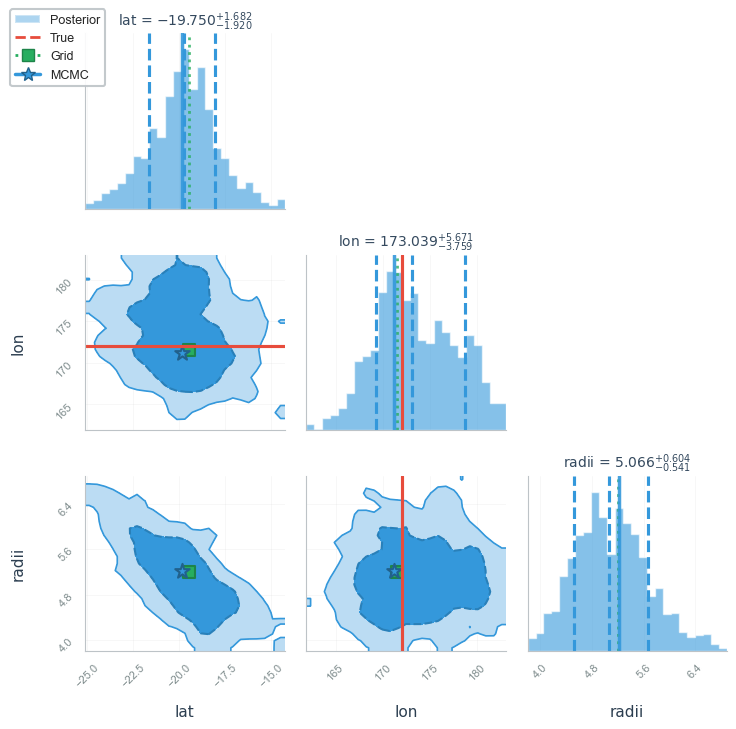

In [71]:
# Extraer datos
flat_samples = data['flat_chain']
mcmc_best = data['best_params']
labels = data.get('labels', ['Latitude [°]', 'Longitude [°]', 'Spot Radius [°]'])

# Tus parámetros
true_params = [19.0, 172.0, 12.0]
grid_params = [-19.5, 171.5, 5.2]



# Crear plot minimalista
fig2 = create_styled_corner_plot(
    flat_samples=flat_samples,
    true_params=true_params,
    grid_params=grid_params,
    mcmc_best=mcmc_best,
    labels=labels,
    style='minimalist',
    save_path='mcmc_minimalist.png'
)

plt.show()